In [1]:
import pandas as pd 
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import ast

In [2]:
# Load mode
load_mode = 'csv' #csv or db
csv_filename = 'historian_v0.csv'

In [3]:
if load_mode == 'db':
    conn = psycopg2.connect(
        dbname="historian",
        user ="postgres",
        password="yS5w162oCw",
        host="localhost",
        port="5432"
    )
    query = """ 
    select 
        time, run_id, category , category_sub , 
        data->'skill' as skill_name, 
        data->'episode_number' as episode,
        data->'obs' as obs,
        data->'reward' as reward,
        data->'raw_action' as action
    from public.events 
    where category in ('base-skill-env','teacher') and category_sub  in ('step','compute-reward')
    order by time 
    """

    df = pd.read_sql(query, conn)

elif load_mode == 'csv':
    df = pd.read_csv(csv_filename)
    df['obs'] = df['obs'].apply(lambda x: ast.literal_eval(x))

In [4]:
df

,Unnamed: 0,time,run_id,category,category_sub,skill_name,episode,obs,reward,action
0,1,2023-10-26 16:09:53.270000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,NaN,NaN,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[-1.2275837659835815]
1,8,2023-10-26 16:10:02.356000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,reaction,2.0,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[5.467321872711182]
2,16,2023-10-26 16:10:02.626000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,reaction,3.0,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[-3.158571720123291]
3,25,2023-10-26 16:10:02.733000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,reaction,3.0,"{'T': 308.891087193425, 'Ca': 8.67071772127075...",12.285191,[3.8708982467651367]
4,28,2023-10-26 16:10:02.733000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,reaction,3.0,"{'T': 309.295815225561, 'Ca': 8.62574472623403...",17.938917,[3.7209901809692383]
...,...,...,...,...,...,...,...,...,...,...
419300,2935101,2023-10-26 17:07:24.460000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,203.0,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[9.094171524047852]
419301,2935103,2023-10-26 17:07:24.460000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,202.0,"{'T': 402.3069485447887, 'Ca': 0.7273880263109...",0.523599,[0.0005283355712890625]
419302,2935107,2023-10-26 17:07:24.460000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,202.0,"{'T': 402.30805828104366, 'Ca': 0.727358057928...",0.528575,[8.487701416015625e-05]
419303,2935124,2023-10-26 17:07:24.461000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,202.0,"{'T': 402.3075401032663, 'Ca': 0.7273720587761...",0.525280,[0.00027561187744140625]


In [5]:
# process
df['episode'] = df.episode.ffill()
df['skill_name'] = df.skill_name.ffill()

df = df.dropna(subset=['obs'])

In [6]:
# infer iterations from data
c = 0
v = 0
iterations = []
for i,row in df.iterrows():
    if i > 0:
        if row['episode'] == v:
            c += 1
        else:
            c = 0
        v = row['episode']
    
    iterations.append(c)

df['iteration'] = iterations

In [7]:
# group by runs
df_group = df.groupby(['run_id','episode'])['reward'].mean()

#group by run_id and episode, with (min, mean, max) reward

In [8]:
df_group

run_id                                episode
5be5d2e6-1d31-4be9-bb82-025b8061bef9  2.0        0.000000
                                      3.0        3.892958
                                      4.0        3.758469
                                      5.0        3.719483
                                      6.0        3.568832
                                                   ...   
c8d22af2-3dd2-449e-bfcb-002af3a6dd32  13.0       1.153418
                                      14.0       1.818898
                                      15.0       2.938209
                                      16.0       6.833367
                                      17.0       2.312868
Name: reward, Length: 4462, dtype: float64

# Training Metrics

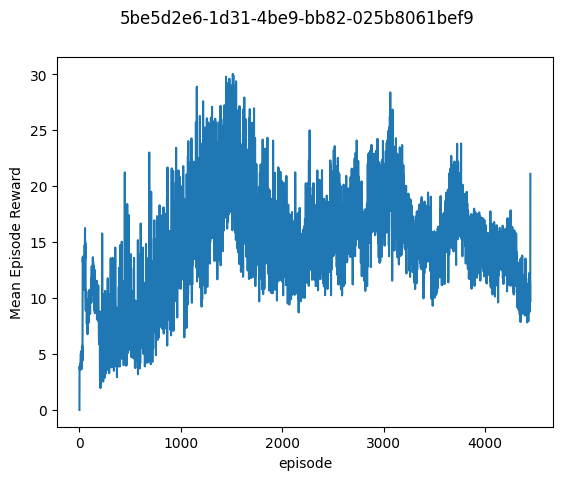

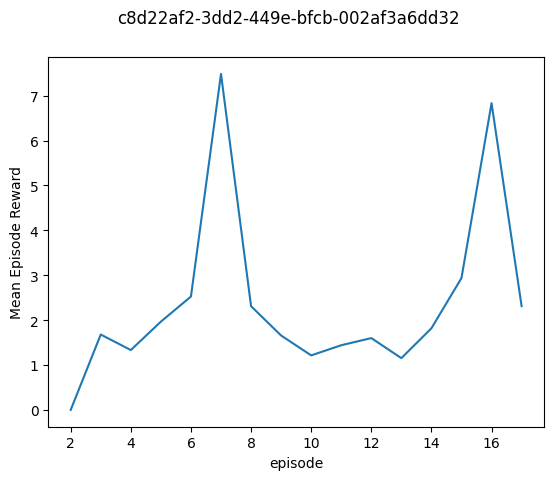

In [9]:
for run_id in list(set([x[0] for x in df_group.index])):
    df_group[run_id].plot(subplots=True, title=run_id)
    plt.ylabel('Mean Episode Reward')
    plt.show()

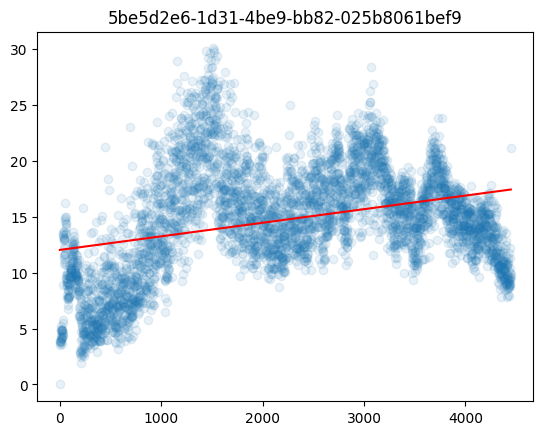

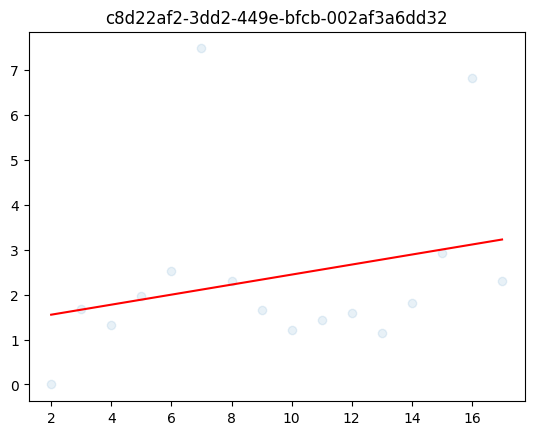

In [10]:
for run_id in list(set([x[0] for x in df_group.index])):
    plt.scatter(df_group[run_id].index, df_group[run_id].reset_index()['reward'], alpha=0.1)
    plt.title(run_id)
    if len(df_group[run_id]) > 10:
        slope, intercept = np.polyfit(df_group[run_id].index, df_group[run_id].reset_index()['reward'], 1)
        plt.plot(df_group[run_id].index, slope * df_group[run_id].index + intercept, 'r')

    plt.show()

In [133]:
#plt.scatter(df['iteration'], df['obs'].apply(lambda x: x['T']), alpha=0.1)
#plt.scatter(df['iteration'], df['obs'].apply(lambda x: x['Tref']), alpha=0.1)

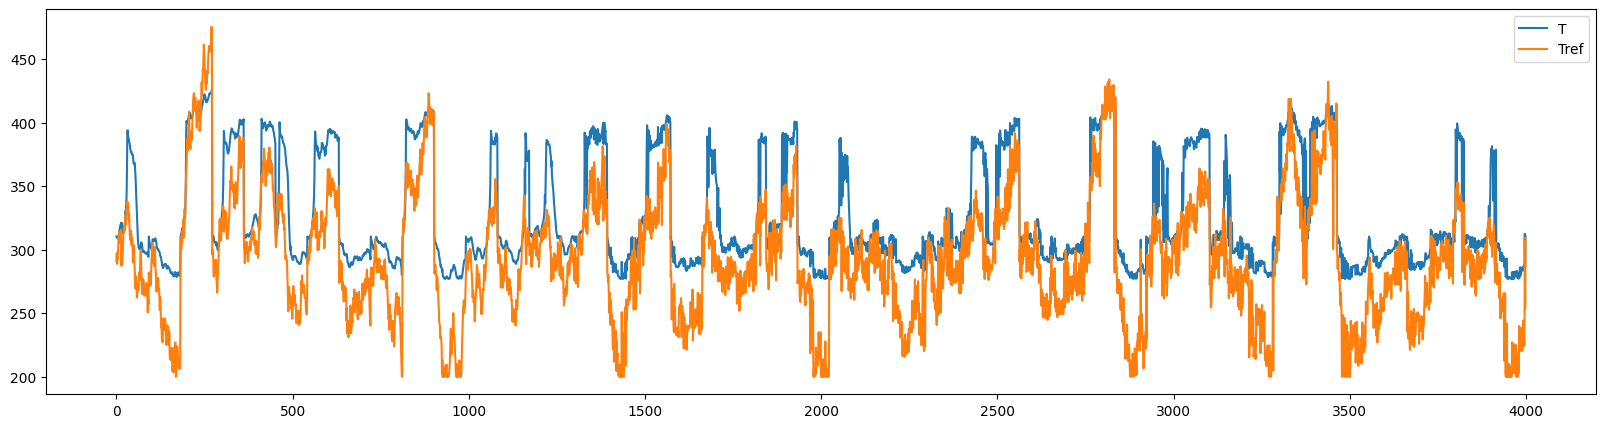

In [15]:
# Analyze how T is following Tref during training
df['obs'].apply(lambda x: x['T'])[:4000].plot(figsize=(20,5))
df['obs'].apply(lambda x: x['Tc'])[:4000].plot(figsize=(20,5))
plt.legend(['T', 'Tref'])

In [ ]:
#conn.close()

# Analayze each run

In [19]:
# Choose a run id
run_id = '5be5d2e6-1d31-4be9-bb82-025b8061bef9'

In [29]:
print('Max Episode: ', df['episode'].max())

# choose an episode to analyze
episode = 4000

Max Episode:  4447.0


In [30]:
# filter by run if
df_filter = df[df['run_id'] == run_id]

/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_60298/3791259793.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Cref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Ca']), alpha=0.4)
/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_60298/3791259793.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Cref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Ca']), alpha=0.4)


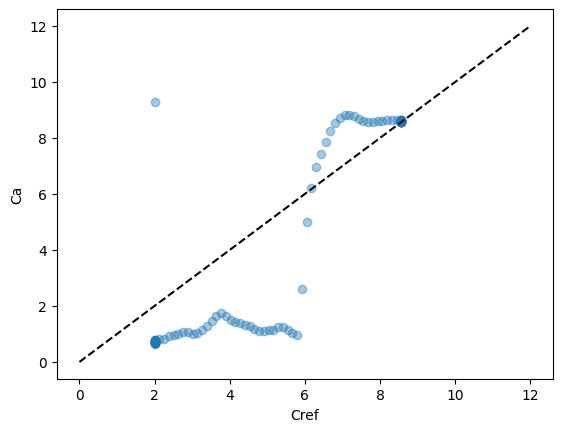

In [41]:
# Analyze how Ca is following Cref
plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Cref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Ca']), alpha=0.4)
plt.xlabel('Cref')
plt.ylabel('Ca')
plt.plot([0, 12], [0, 12], 'k--')

/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_60298/3978899726.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Tref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.4)
/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_60298/3978899726.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Tref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.4)


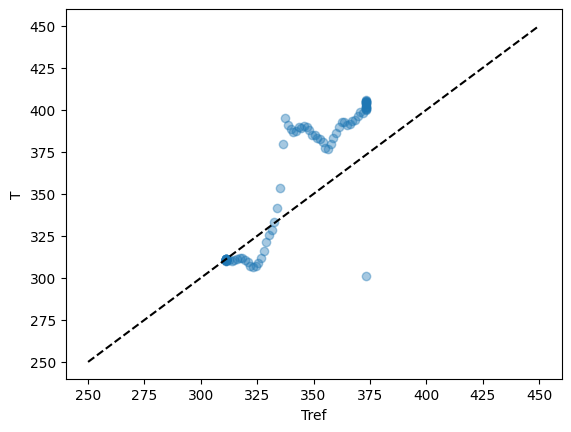

In [44]:
# Analyze how T is following Tref
plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Tref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.4)
plt.xlabel('Tref')
plt.ylabel('T')
plt.plot([250, 450], [250, 450], 'k--')

### Analyze By iteration

/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_60298/4111285319.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['iteration'], df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.9)
/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_60298/4111285319.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['iteration'], df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.9)
/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_60298/4111285319.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['iteration'], df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Tref']), alpha=0.9)
/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_60298/4111285319.py:2: UserWarning:

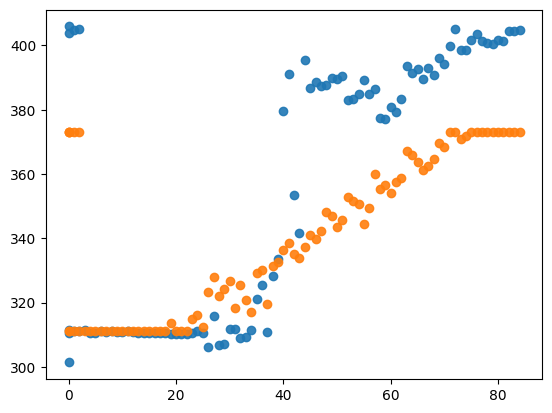

In [34]:
plt.scatter(df_filter[df['episode'] == episode]['iteration'], df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.9)
plt.scatter(df_filter[df['episode'] == episode]['iteration'], df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Tref']), alpha=0.9)

/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_60298/2315466695.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df_filter[df['episode'] == episode]['iteration'][:90],df_filter[df['episode'] == episode].reset_index()['obs'].apply(lambda x: x['Tref'])[:90])
/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_60298/2315466695.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df_filter[df['episode'] == episode]['iteration'][:90],df_filter[df['episode'] == episode].reset_index()['obs'].apply(lambda x: x['Tref'])[:90])


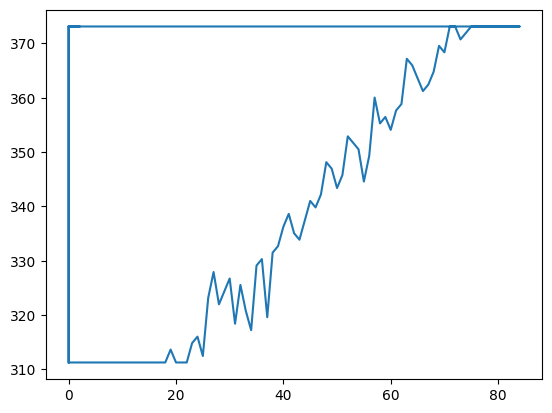

In [33]:
#plt.scatter(df_filter[df['episode'] == episode]['time'][:88],df_filter[df['episode'] == episode].reset_index()['obs'].apply(lambda x: x['T'])[:88])
plt.plot(df_filter[df['episode'] == episode]['iteration'][:90],df_filter[df['episode'] == episode].reset_index()['obs'].apply(lambda x: x['Tref'])[:90])